In [2]:
# analyze TD regression for RBs
# leverage nfl_data_py module to pull nfl data

# % is magic command for us to install external libraries
# use capture to supress output of the install
%%capture
%pip install nfl_data_py --upgrade

In [3]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import warnings; warnings.simplefilter('ignore')

In [4]:
seasons = range(2008, 2022)
df = nfl.import_pbp_data(seasons)

2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


In [5]:
df.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(676290, 384)

In [7]:
rushing_df = df[['rush_attempt', 'rush_touchdown', 'yardline_100', 'two_point_attempt']]
rushing_df = rushing_df.loc[(rushing_df['rush_attempt'] == 1) & (rushing_df['two_point_attempt'] == 0)]

rushing_df.head()

,rush_attempt,rush_touchdown,yardline_100,two_point_attempt
2,1.0,0.0,80.0,0.0
8,1.0,0.0,19.0,0.0
9,1.0,0.0,10.0,0.0
11,1.0,0.0,7.0,0.0
15,1.0,0.0,95.0,0.0


In [8]:
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts(normalize=True)
rushing_df_probs = pd.DataFrame({
    'probability_of_touchdown': rushing_df_probs.values
}, index=rushing_df_probs.index).reset_index()

In [9]:
rushing_df_probs = rushing_df_probs.loc[rushing_df_probs['rush_touchdown'] == 1]
rushing_df_probs_clean = rushing_df_probs.drop('rush_touchdown', axis=1)
rushing_df_probs_clean.head(15)

,yardline_100,probability_of_touchdown
0,1.0,0.554529
3,2.0,0.413125
5,3.0,0.335971
7,4.0,0.279770
9,5.0,0.205882
11,6.0,0.156932
13,7.0,0.147353
15,8.0,0.133047
17,9.0,0.084093
19,10.0,0.091549


<Axes: xlabel='yardline_100'>

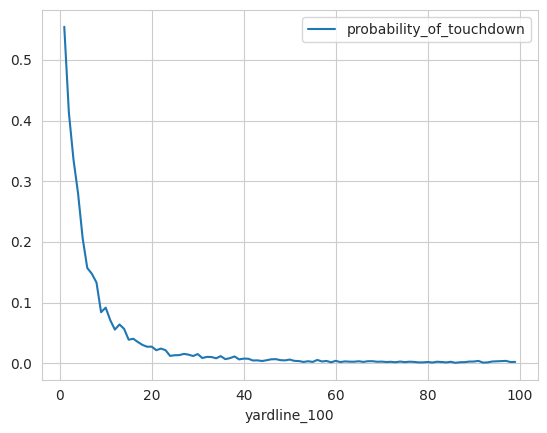

In [10]:
import seaborn as sns;
sns.set_style('whitegrid')
rushing_df_probs_clean.plot(x='yardline_100', y='probability_of_touchdown')

In [11]:
pbp_2022 = nfl.import_pbp_data([2022])
pbp_2022 = pbp_2022[['rusher_player_name', 'rusher_player_id', 'posteam', 'rush_touchdown', 'yardline_100']].dropna()

2022 done.
Downcasting floats.


In [12]:
pbp_2022.head()

,rusher_player_name,rusher_player_id,posteam,rush_touchdown,yardline_100
2,Mi.Carter,00-0036924,NYJ,0.0,78.0
4,Mi.Carter,00-0036924,NYJ,0.0,59.0
9,L.Jackson,00-0034796,BAL,0.0,64.0
10,K.Drake,00-0033118,BAL,0.0,60.0
12,K.Drake,00-0033118,BAL,0.0,52.0


In [13]:
exp_df = pbp_2022.merge(rushing_df_probs_clean, how='left', on='yardline_100')
exp_df.head()

,rusher_player_name,rusher_player_id,posteam,rush_touchdown,yardline_100,probability_of_touchdown
0,Mi.Carter,00-0036924,NYJ,0.0,78.0,0.001346
1,Mi.Carter,00-0036924,NYJ,0.0,59.0,0.001527
2,L.Jackson,00-0034796,BAL,0.0,64.0,0.002457
3,K.Drake,00-0033118,BAL,0.0,60.0,0.003909
4,K.Drake,00-0033118,BAL,0.0,52.0,0.003516


In [16]:
exp_df_grouped = exp_df.groupby(['rusher_player_name', 'rusher_player_id', 'posteam'], as_index=False).agg({
    'probability_of_touchdown': np.sum,
    'rush_touchdown': np.sum
}).rename({
    'probability_of_touchdown': 'Expected Touchdowns',
    'rush_touchdown': 'Actual Touchdowns'
}, axis=1)

exp_df_grouped = exp_df_grouped.sort_values(by='Expected Touchdowns', ascending=False)

exp_df_grouped.head()

,rusher_player_name,rusher_player_id,posteam,Expected Touchdowns,Actual Touchdowns
214,Ja.Williams,00-0033948,DET,17.408436,17.0
180,J.Hurts,00-0036389,PHI,15.284469,18.0
132,E.Elliott,00-0033045,DAL,11.319867,12.0
193,J.Mixon,00-0033897,CIN,11.221726,8.0
85,D.Cook,00-0033893,MIN,9.635063,8.0


In [19]:
exp_df_clean = exp_df_grouped.rename(columns={
    'rusher_player_name': 'Player',
    'posteam': 'Team',
    'rusher_player_id': 'ID'
})

exp_df_clean.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns
214,Ja.Williams,00-0033948,DET,17.408436,17.0
180,J.Hurts,00-0036389,PHI,15.284469,18.0
132,E.Elliott,00-0033045,DAL,11.319867,12.0
193,J.Mixon,00-0033897,CIN,11.221726,8.0
85,D.Cook,00-0033893,MIN,9.635063,8.0


In [23]:
roster = nfl.import_rosters([2022])
roster = roster[['player_id', 'position']].rename({
    'player_id': 'ID'
}, axis=1)
roster.head()

,ID,position
0,00-0029747,DB
1,00-0032560,DB
2,00-0032933,DB
3,00-0033890,DB
4,00-0033568,DB


In [25]:
exp_df_merge_roster = exp_df_clean.merge(roster, on='ID', how='left')
exp_df_merge_roster.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,position
0,Ja.Williams,00-0033948,DET,17.408436,17.0,RB
1,J.Hurts,00-0036389,PHI,15.284469,18.0,QB
2,E.Elliott,00-0033045,DAL,11.319867,12.0,RB
3,J.Mixon,00-0033897,CIN,11.221726,8.0,RB
4,D.Cook,00-0033893,MIN,9.635063,8.0,RB


In [26]:
exp_df_rb = exp_df_merge_roster.loc[exp_df_merge_roster['position'] == 'RB'].drop('position', axis=1)
exp_df_rb.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns
0,Ja.Williams,00-0033948,DET,17.408436,17.0
2,E.Elliott,00-0033045,DAL,11.319867,12.0
3,J.Mixon,00-0033897,CIN,11.221726,8.0
4,D.Cook,00-0033893,MIN,9.635063,8.0
5,J.Jacobs,00-0035700,LV,9.371359,12.0


In [27]:
exp_df_rb['Actual Touchdowns Rank'] = exp_df_rb['Actual Touchdowns'].rank(ascending=False)
exp_df_rb.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Actual Touchdowns Rank
0,Ja.Williams,00-0033948,DET,17.408436,17.0,1.0
2,E.Elliott,00-0033045,DAL,11.319867,12.0,6.5
3,J.Mixon,00-0033897,CIN,11.221726,8.0,12.5
4,D.Cook,00-0033893,MIN,9.635063,8.0,12.5
5,J.Jacobs,00-0035700,LV,9.371359,12.0,6.5


In [29]:
exp_df_rb['Regression Candidate'] = exp_df_rb['Expected Touchdowns'] - exp_df_rb['Actual Touchdowns']
exp_df_rb.sort_values(by='Regression Candidate', ascending=False)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Actual Touchdowns Rank,Regression Candidate
18,T.Allgeier,00-0037263,ATL,6.622854,3.0,42.0,3.622854
20,L.Fournette,00-0033856,TB,6.444318,3.0,42.0,3.444318
30,B.Robinson,00-0037746,WAS,5.389459,2.0,56.5,3.389459
6,T.Etienne,00-0036973,JAX,9.325063,6.0,19.0,3.325063
3,J.Mixon,00-0033897,CIN,11.221726,8.0,12.5,3.221726
...,...,...,...,...,...,...,...
31,T.Pollard,00-0035261,DAL,5.301556,9.0,10.0,-3.698444
12,N.Chubb,00-0034791,CLE,8.285513,12.0,6.5,-3.714487
7,M.Sanders,00-0035243,PHI,9.252068,13.0,3.5,-3.747932
8,D.Henry,00-0032764,TEN,8.902119,13.0,3.5,-4.097881


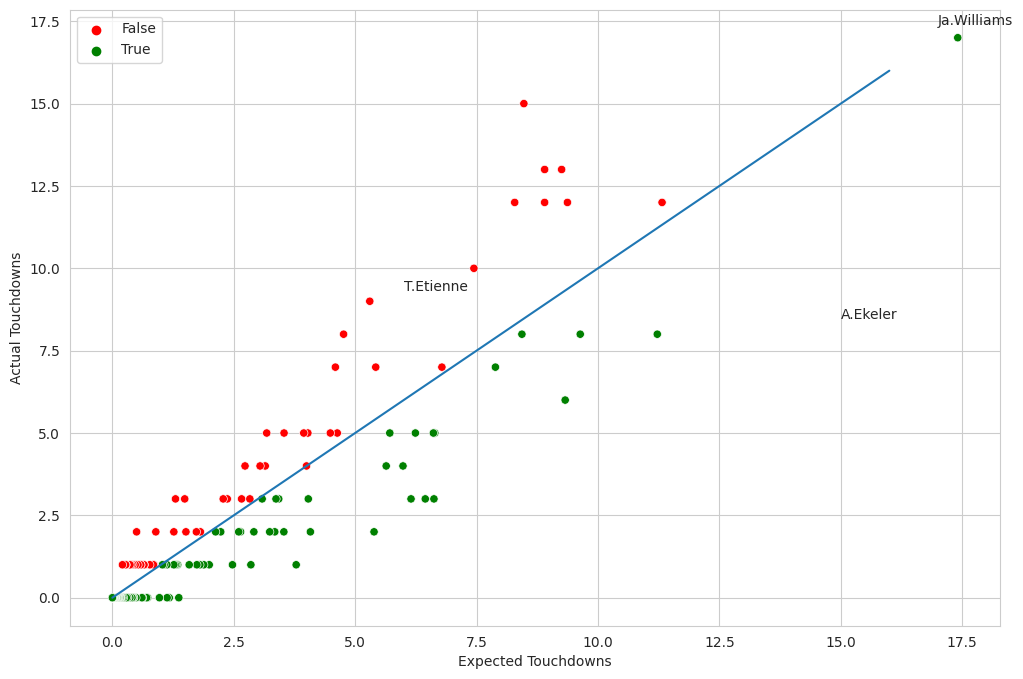

In [35]:
from matplotlib import pyplot as plt;

fig, ax = plt.subplots(figsize=(12, 8))
exp_df_rb['Positive Regression Candidate'] = exp_df_rb['Regression Candidate'] > 0
sns.scatterplot(
    data=exp_df_rb,
    x='Expected Touchdowns',
    y='Actual Touchdowns',
    hue='Positive Regression Candidate',
    palette=['r','g']
)

max_actual_touchdowns = int(exp_df_rb['Actual Touchdowns'].max())
max_expected_touchdowns = int(exp_df_rb['Expected Touchdowns'].max())
max_tds = max(max_actual_touchdowns, max_expected_touchdowns)

sns.lineplot(x=range(max_tds), y=range(max_tds))

notable_players = ['T.Etienne', 'Ja.Williams', 'A.Ekeler']

for _, row in exp_df_rb.iterrows():
  if row['Player'] in notable_players:
    ax.text(
        x=row['Actual Touchdowns'],
        y=row['Expected Touchdowns'],
        s=row['Player']
    )